In [ ]:
# For this skeleton, you need to install torchtext, and optionally spacy. 
# It also uses pretrained word embeddings from glove.6B.100d which is around 850 MB. You can skip using it if you don't have enough 
# memory to work with. But training will be faster if you use it.

In [183]:
from torchtext import data
from torchtext import datasets
import torch
import torch.nn as nn
import torch.optim as optim
import time
import pandas as pd
import spacy
import re
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [69]:
#### Section 1: Spacy (optional) ###
# Uncomment this lines if you are using spacy
nlp = spacy.load('en_core_web_sm')
prefix_re = spacy.util.compile_prefix_regex(nlp.Defaults.prefixes)
suffix_re = spacy.util.compile_suffix_regex(nlp.Defaults.suffixes)
infix_re = re.compile(r'''[-~]''')
!python -m spacy download en_core_web_sm
nlp = spacy.load('en_core_web_sm')

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [70]:
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [71]:
#### Section 2: Tokenizer ###
# create a tokenizer function
def tokenizer(text): 
    # return a list of words. You may skip the stop words defined by spacy or nltk lib
    doc = nlp(text)
    result = []
    for token in doc:
        ent = nlp.vocab[token.text]
        if ent.is_stop == False:
            result.append(token.text)
    return result

In [72]:
def tokenizer(text):
    my_doc = nlp(text)
    token_list = []
    for token in my_doc:
        token_list.append(token.text)
    filtered_sentence = []
    for word in token_list:
        lexeme = nlp.vocab[word]
        if lexeme.is_stop == False:
            filtered_sentence.append(word)
    return filtered_sentence

In [73]:
TEXT = data.Field(tokenize = tokenizer, lower=True, include_lengths = True)
LABEL = data.LabelField(dtype = torch.long)
fields = {'reviewText': ('t', TEXT), 'sentiment': ('l', LABEL)}

In [107]:
#### Section 3: Datasets ###
# while you experiment, use the small datasets. Final training and evaluation needs to be done with large datasets. 
#suffix = 'small-'
suffix = 'large-'
dataFolder = '/Users/dmy/Downloads' # keep all your data files in a single folder

train_data, valid_data, test_data = data.TabularDataset.splits(
                                        path = dataFolder, 
                                        train = suffix + 'clean-train.json', # json file
                                        validation = suffix + 'clean-val.json',# json file
                                        test = suffix + 'clean-val.json',# json file
                                        format = 'json', # json file
                                        fields = fields
)

In [108]:
#### Section 4: Vocabulary ###

# You can use GloVe vocabulary to train your model faster towards convergence or build up your own embeddings. 
# If you are not using the GloVe embeddings, you will need to comment out the embedding weight transfer to model in 
# Section 9

MAX_VOCAB_SIZE = 25_000

#Local vocabulary
# TEXT.build_vocab(train_data, max_size = MAX_VOCAB_SIZE)
# LABEL.build_vocab(train_data)

#GloVe vocabulary
TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)
LABEL.build_vocab(train_data)

# Check if it worked
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')
print(vars(train_data[0]))

Number of training examples: 53760
Number of testing examples: 30240
{'t': ['koi', 'scrub', 'pants', 'fit', 'better', '.'], 'l': 'bad'}


In [109]:
#### Section 5: Iterators ###
# Iterators organizes datasets into batches and feeds them into the model. In this skeletion, we use packed padded sequence
# to make sure that all the input data points are of the same size and they do not incur unnecessary computation. Read more 
# about packed padded sequence here: https://stackoverflow.com/questions/51030782/why-do-we-pack-the-sequences-in-pytorch
# For that, we need to sort the samples in each batch in decreasing order of number of words.

BATCH_SIZE = 32

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    sort = False, 
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    sort_key = lambda x: len(x.t),
    device = device)

In [110]:
#### Section 6: Vanilla RNN ###

class VanillaRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        # Add your network's trainable layers here.
        self.rnn = nn.RNN(embedding_dim, 
                          hidden_dim, 
                          num_layers=n_layers, 
                          bidirectional=bidirectional, 
                          dropout=dropout)
    
        self.fc1 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text, text_lengths):
        
        #text = [sent len, batch size]
        
 #        embedded = self.dropout(self.embedding(text))
        embedded = self.embedding(text)
        
        #embedded = [sent len, batch size, emb dim]
        
        #pack sequence. Clambing the lengths to avoid errors in some bugs
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.clamp(min=1, max=50))
        
        # now packed_embedded is the input to your model. You can do whatever you want to do from this point
        packed_output, hidden = self.rnn(packed_embedded)
        output = self.fc1(hidden[-1,:,:])

        return output


In [192]:
#### Section 7: Advanced Model ###

class AdvancedModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        # Add your network's trainable layers here.
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
    
        
    def forward(self, text, text_lengths):
        
        #text = [sent len, batch size]
        
       # embedded = self.dropout(self.embedding(text))
        embedded = self.embedding(text)
        #embedded = [sent len, batch size, emb dim]
        
        #pack sequence. Clambing the lengths to avoid errors in some bugs
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.clamp(min=1, max=50))
        
        # now packed_embedded is the input to your model. You can do whatever you want to do from this point
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        output = self.fc1(hidden)
        output = self.dropout(self.fc2(output))
                
        #hidden = [batch size, hid dim * num directions]
            
        return output

In [126]:
#### Section 8: Create your models ###
### A.Vanilla RNN
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 3
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = VanillaRNN(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)


In [193]:
#### Section 8: Create your models ###
### LSTM RNN
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 3
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

modelL = AdvancedModel(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)


In [188]:
#### Section 9: Transfer pretrained weights for word embeddings from GloVe ###
# Must be commented out if you are not using GloVe embeddings

### Vanilla RNN

pretrained_embeddings = TEXT.vocab.vectors
print(pretrained_embeddings.shape)
model.embedding.weight.data.copy_(pretrained_embeddings)

torch.Size([19272, 100])


tensor([[ 0.5856,  0.1937,  2.7073,  ..., -0.0805,  2.0212, -0.2180],
        [ 0.9062, -0.6399, -2.0356,  ...,  0.2262,  0.2828, -1.4489],
        [-0.3398,  0.2094,  0.4635,  ..., -0.2339,  0.4730, -0.0288],
        ...,
        [-0.3582, -1.1579, -0.1634,  ...,  0.5312, -0.8237, -0.3024],
        [-0.1346,  1.4445,  0.0270,  ...,  0.1019, -0.3709, -0.7011],
        [-0.5231,  1.1769, -0.6864,  ..., -0.2238, -1.0347,  0.8426]])

In [195]:
### B. LSTM RNN

pretrained_embeddings = TEXT.vocab.vectors
print(pretrained_embeddings.shape)
modelL.embedding.weight.data.copy_(pretrained_embeddings)

torch.Size([19272, 100])


tensor([[ 0.5856,  0.1937,  2.7073,  ..., -0.0805,  2.0212, -0.2180],
        [ 0.9062, -0.6399, -2.0356,  ...,  0.2262,  0.2828, -1.4489],
        [-0.3398,  0.2094,  0.4635,  ..., -0.2339,  0.4730, -0.0288],
        ...,
        [-0.3582, -1.1579, -0.1634,  ...,  0.5312, -0.8237, -0.3024],
        [-0.1346,  1.4445,  0.0270,  ...,  0.1019, -0.3709, -0.7011],
        [-0.5231,  1.1769, -0.6864,  ..., -0.2238, -1.0347,  0.8426]])

In [189]:
#### Section 10: Optimizer and Loss 
# Feel free to use any you want
### Vanilla RNN
optimizer = optim.Adam(model.parameters())

#criterion = nn.NLLLoss()
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)


In [196]:
### LSTM RNN
optimizer = optim.Adam(modelL.parameters())

#criterion = nn.NLLLoss()
criterion = nn.CrossEntropyLoss()

modelL = modelL.to(device)
criterion = criterion.to(device)


In [115]:
def accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    predictedLabel = torch.argmax(torch.exp(preds), dim=1)
    correct = (predictedLabel == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [116]:
#### Section 11: Training process
# Feel free to change
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        text, text_lengths = batch.t
        
        predictions = model(text, text_lengths).squeeze(1)
        
        loss = criterion(predictions, batch.l)
        
        acc = accuracy(predictions, batch.l)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [117]:
#### Section 11: Evaluation process
# Feel free to change
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            text, text_lengths = batch.t
            
            predictions = model(text, text_lengths).squeeze(1)
            
            loss = criterion(predictions, batch.l)
            
            acc = accuracy(predictions, batch.l)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [118]:

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [190]:
#### Section 12: Train

# You need to change this name for each model.
t1 = time.time()
loss1=[]
acc1=[]
val_acc1=[]
modelOutputName = 'vanilla-rnn.pt'

N_EPOCHS = 50

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), modelOutputName)
    loss1.append(train_loss)
    acc1.append(train_acc)
    val_acc1.append(valid_acc)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 2m 10s
	Train Loss: 0.707 | Train Acc: 70.46%
	 Val. Loss: 0.662 |  Val. Acc: 72.47%
Epoch: 02 | Epoch Time: 2m 9s
	Train Loss: 0.611 | Train Acc: 74.57%
	 Val. Loss: 0.617 |  Val. Acc: 74.17%
Epoch: 03 | Epoch Time: 2m 8s
	Train Loss: 0.549 | Train Acc: 77.62%
	 Val. Loss: 0.617 |  Val. Acc: 75.03%
Epoch: 04 | Epoch Time: 2m 9s
	Train Loss: 0.516 | Train Acc: 79.35%
	 Val. Loss: 0.603 |  Val. Acc: 75.61%
Epoch: 05 | Epoch Time: 2m 17s
	Train Loss: 0.492 | Train Acc: 80.28%
	 Val. Loss: 0.613 |  Val. Acc: 75.72%
Epoch: 06 | Epoch Time: 2m 20s
	Train Loss: 0.467 | Train Acc: 81.58%
	 Val. Loss: 0.621 |  Val. Acc: 76.25%
Epoch: 07 | Epoch Time: 2m 23s
	Train Loss: 0.449 | Train Acc: 82.52%
	 Val. Loss: 0.619 |  Val. Acc: 75.93%
Epoch: 08 | Epoch Time: 2m 25s
	Train Loss: 0.437 | Train Acc: 82.90%
	 Val. Loss: 0.610 |  Val. Acc: 76.06%
Epoch: 09 | Epoch Time: 2m 25s
	Train Loss: 0.422 | Train Acc: 83.72%
	 Val. Loss: 0.611 |  Val. Acc: 76.57%
Epoch: 10 | Epoch Time

In [197]:
#### Section 12: Train

# You need to change this name for each model.
t2 = time.time()
loss2=[]
acc2=[]
val_acc2=[]
modelOutputName = 'LSTM-rnn.pt'

N_EPOCHS = 30

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(modelL, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(modelL, valid_iterator, criterion)
     
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(modelL.state_dict(), modelOutputName)
    loss2.append(train_loss)
    acc2.append(train_acc)
    val_acc2.append(valid_acc)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\t Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 7m 14s
	Train Loss: 0.630 | Train Acc: 73.47%
	 Val. Loss: 0.553 |  Val. Acc: 77.19%
Epoch: 02 | Epoch Time: 8m 10s
	Train Loss: 0.506 | Train Acc: 79.35%
	 Val. Loss: 0.533 |  Val. Acc: 77.77%
Epoch: 03 | Epoch Time: 8m 52s
	Train Loss: 0.424 | Train Acc: 83.13%
	 Val. Loss: 0.565 |  Val. Acc: 77.96%
Epoch: 04 | Epoch Time: 9m 15s
	Train Loss: 0.341 | Train Acc: 86.69%
	 Val. Loss: 0.575 |  Val. Acc: 77.38%
Epoch: 05 | Epoch Time: 8m 39s
	Train Loss: 0.256 | Train Acc: 90.41%
	 Val. Loss: 0.730 |  Val. Acc: 77.01%
Epoch: 06 | Epoch Time: 7m 13s
	Train Loss: 0.180 | Train Acc: 93.31%
	 Val. Loss: 0.808 |  Val. Acc: 77.41%
Epoch: 07 | Epoch Time: 7m 18s
	Train Loss: 0.120 | Train Acc: 95.59%
	 Val. Loss: 1.145 |  Val. Acc: 76.76%
Epoch: 08 | Epoch Time: 7m 23s
	Train Loss: 0.080 | Train Acc: 97.04%
	 Val. Loss: 1.293 |  Val. Acc: 77.00%
Epoch: 09 | Epoch Time: 10m 23s
	Train Loss: 0.057 | Train Acc: 98.00%
	 Val. Loss: 1.603 |  Val. Acc: 76.16%
Epoch: 10 | Epoch 

Since I used MacBook to run the code, it was so slowly. I don't have enough time to run 50 epochs, so I used epoch = 30

<function matplotlib.pyplot.show(close=None, block=None)>

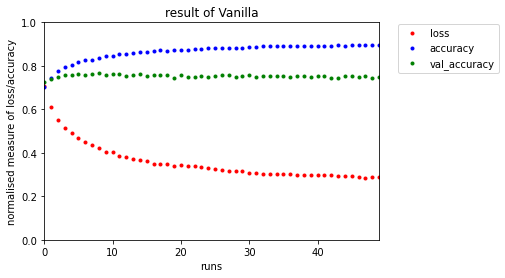

In [191]:
#### Section 13: Plots
plt.xlabel("runs")
plt.ylabel("normalised measure of loss/accuracy")
x_len=list(range(len(acc1)))
plt.axis([0, max(x_len), 0, 1])
plt.title('result of Vanilla')
loss=np.asarray(loss1)/max(loss1)
plt.plot(x_len, loss1, 'r.',label="loss")
plt.plot(x_len, acc1, 'b.', label="accuracy")
plt.plot(x_len, val_acc1, 'g.', label="val_accuracy")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.2)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

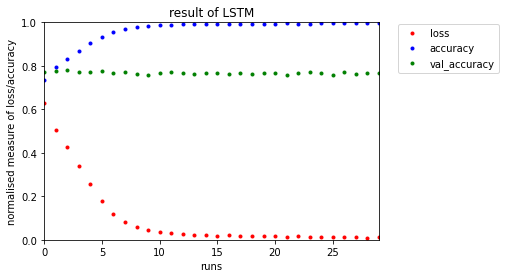

In [198]:
plt.xlabel("runs")
plt.ylabel("normalised measure of loss/accuracy")
x_len=list(range(len(acc2)))
plt.axis([0, max(x_len), 0, 1])
plt.title('result of LSTM')
loss=np.asarray(loss2)/max(loss2)
plt.plot(x_len, loss2, 'r.',label="loss")
plt.plot(x_len, acc2, 'b.', label="accuracy")
plt.plot(x_len, val_acc2, 'g.', label="val_accuracy")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.2)
plt.show

In [165]:
#### Section 14: Test Code

# 1. Load a saved model
# 2. evaluate against the validation set (you will need to create )


In [199]:
model_name = 'vanillaRNN_model.sav'
pickle.dump(model, open(model_name, 'wb'))

In [200]:
modelL_name = 'LSTM_model.sav'
pickle.dump(modelL, open(modelL_name, 'wb'))

In [201]:

# load the model from disk
model_name = 'vanillaRNN_model.sav'
#model_name = 'LSTM_model.sav' # We can switch model 

loaded_model = pickle.load(open(model_name, 'rb'))

# reading test data
#file_name = 'large-clean-test.json'
test_data = data.TabularDataset(
            path = dataFolder+'/'+file_name, 
            #test = file_name, #e.g. file_name = 'large-clean-test.json'
            format = 'json', # json file
            fields = fields)
# processing test data 
test_iterator = data.BucketIterator(
    test_data, 
    sort = False, 
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    sort_key = lambda x: len(x.t),
    device = device)
# evaluate against test data
test_loss, test_acc = evaluate(loaded_model,test_iterator,criterion)
print(f'Test. Acc: {test_acc*100:.2f}%')

Test. Acc: 82.70%


In [149]:
#### Section 15: Application
def predict_sentiment(model, sentence):
    model.eval()
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    length = [len(indexed)]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    length_tensor = torch.LongTensor(length)
    print(model(tensor, length_tensor))
    
    prediction = torch.argmax(torch.exp(model(tensor, length_tensor)), dim=1)
    return LABEL.vocab.itos[prediction.item()]

In [151]:
predict_sentiment(model, "This film is terrible")

tensor([[-3.4553,  3.5597, -0.1363]], grad_fn=<AddmmBackward>)


'bad'

In [152]:
predict_sentiment(modelL, "This film is great")

tensor([[  7.5712, -11.5704,   3.9762]], grad_fn=<AddmmBackward>)


'good'